In [1]:
import control as ctrl
import numpy as np
import matplotlib.pyplot as plt

# Problema de levitador magnético 

Definimos el sistema en estudio

In [2]:
G=ctrl.tf(-40,[1,20,-100,-2000])
G

TransferFunction(array([-40]), array([    1,    20,  -100, -2000]))

In [3]:
G.pole()

array([ 10., -20., -10.])

In [4]:
s=ctrl.tf('s')

Otra forma de definirlo:

In [5]:
Gs=-40/((s+20)*(s**2-100))
Gs

TransferFunction(array([-40]), array([    1,    20,  -100, -2000]))

Lo analizamos con el bode

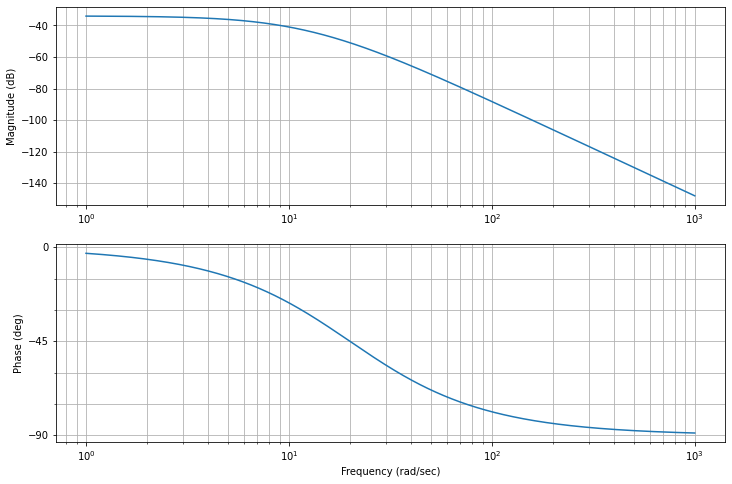

In [6]:
ctrl.bode(Gs, dB=True)
plt.gcf().set_size_inches(12,8)

In [7]:
zeta=0.46
sv=np.exp(-np.pi*zeta/(np.sqrt(1-zeta**2)))
sv

0.19641014802711199

Obtenermos el $\omega_n$

In [8]:
wn=4/0.4/0.46
wn

21.73913043478261

Del resutlado anterior defino $\omega_c=22$, calculo la ganancia necesaria para obtener esa frecuencia de corte

In [9]:
wc=22
k1=1/np.abs(G(wc*1j))
k1

434.08920742170034

In [10]:
ctrl.stability_margins(G*k1)

(inf, 132.27368900609372, inf, nan, 22.0, nan)

In [11]:
T=ctrl.feedback(k1*G)
T.pole()

array([-21.27108628+20.16268541j, -21.27108628-20.16268541j,
        22.54217255 +0.j        ])

Vemos que hicimos un controlador inestable. Vamos a estudiar la estabildad con Nyquist (en la pizarra). Luego verificamos con el Nyquist.

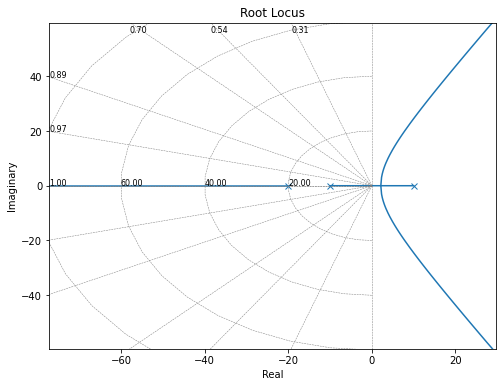

In [12]:
ctrl.rlocus(-G);
plt.gcf().set_size_inches(8,6)

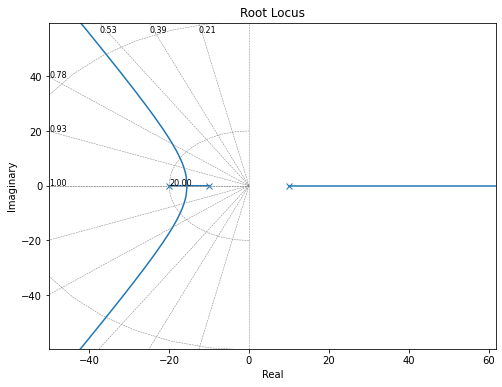

In [13]:
ctrl.rlocus(G);
plt.gcf().set_size_inches(8,6)

Vemos que pasa en la frecuencia de cruce que necesitamos

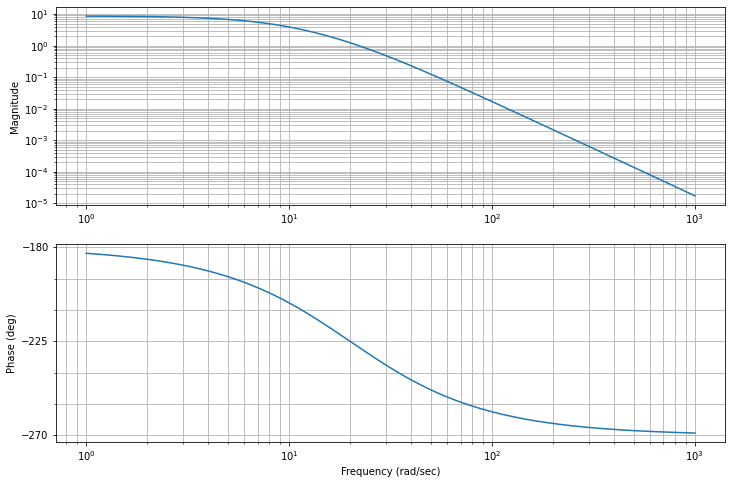

In [14]:
ctrl.bode(-k1*G);
plt.gcf().set_size_inches(12,8)

In [15]:
ctrl.stability_margins(-k1*G)

(0.11518369760210831,
 -47.72631099390625,
 0.7892414128612042,
 0.0,
 22.0,
 24.287786023047357)

Podemos ver que el sistema neceista más de 90 grados lo cual es imposible de conseguir con un solo cero. Vamos a tener que agregar un cero y un lead como mínimo. 

Vamos a tratar de agregar un cero, en algún lugar que no molesta al transitorio pero que agrega fase. Este lugar podria ser -10, tapando el polo real negativo de la planta.

In [16]:
d1=(s+10)

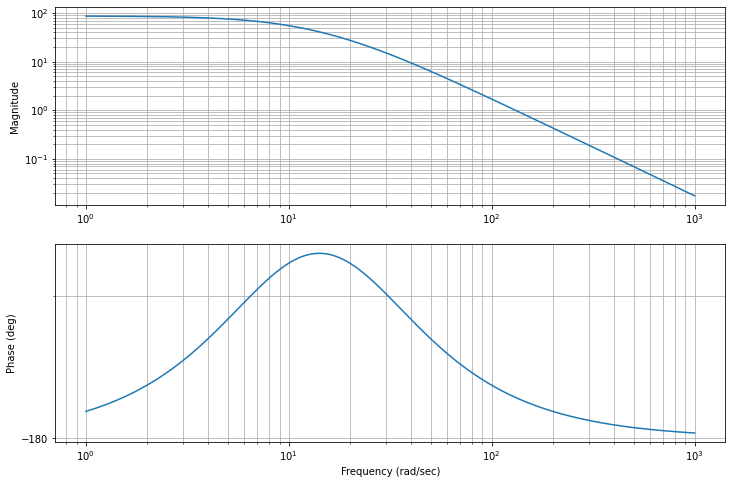

In [17]:
ctrl.bode(-k1*G*d1);
plt.gcf().set_size_inches(12,8)

In [18]:
phi_max=50*np.pi/180
alpha = (1-np.sin(phi_max))/(1+np.sin(phi_max))
alpha

0.13247433143179424

In [19]:
wmax=22
TD=1/(wmax*np.sqrt(alpha))
z=-1/TD
p=-1/(alpha*TD)
z, p

(-8.007345153856452, -60.444503228001686)

In [20]:
d2=(-s/z+1)/(-s/p+1)
d2

TransferFunction(array([ 60.44450323, 484.        ]), array([  8.00734515, 484.        ]))

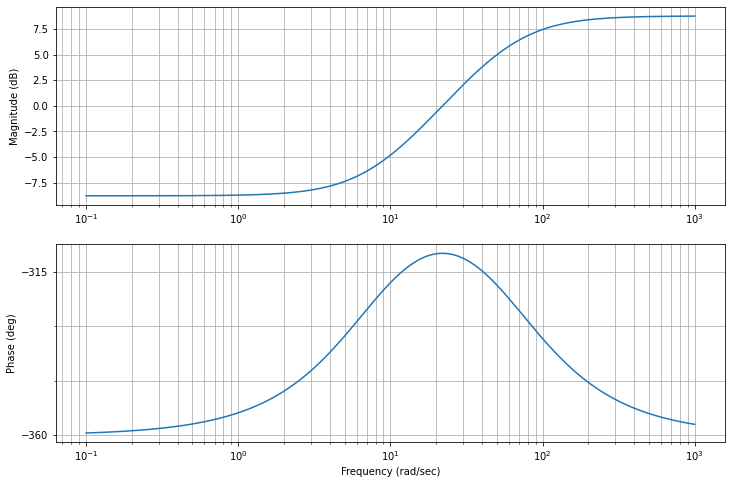

In [21]:
kd2=1/np.abs(d2(wc*1j))
ctrl.bode(d2*kd2, dB=True);
plt.gcf().set_size_inches(12,8)

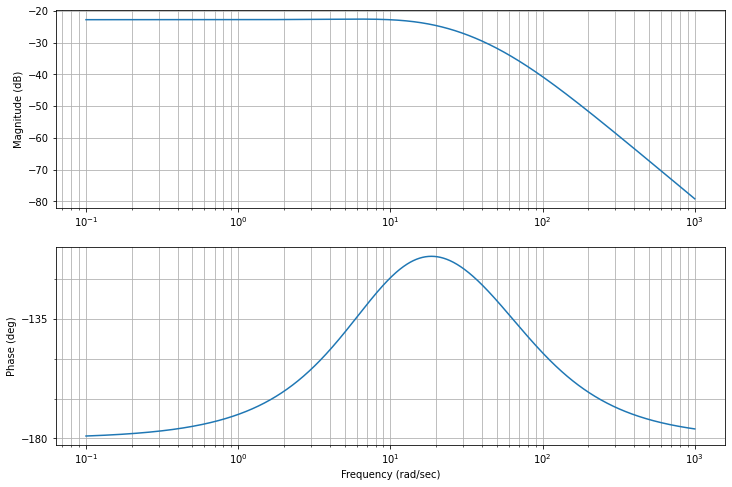

In [22]:
C1=d1*d2*kd2
ctrl.bode(-G*d1*d2*kd2, dB=True);
fig=plt.gcf()
fig.set_size_inches(12,8)

In [23]:
k3=1/np.abs((-G*d1*d2*kd2)(22j))
k3

17.96273921204669

In [24]:
T=ctrl.feedback(-G*d1*d2*kd2*k3)
T.pole()

array([-34.40165524+32.89590354j, -34.40165524-32.89590354j,
       -10.         +0.j        ,  -1.64119275 +0.j        ])

Vemos que este diseno no resultó del todo correcto. Este se debe a varias razones:
- poca ganancia en estado estacionario
- un polo negativo chico que resulta dominante frente a los que diseñamos

In [25]:
t,y=ctrl.step_response(T, T=np.linspace(0,5,2000))

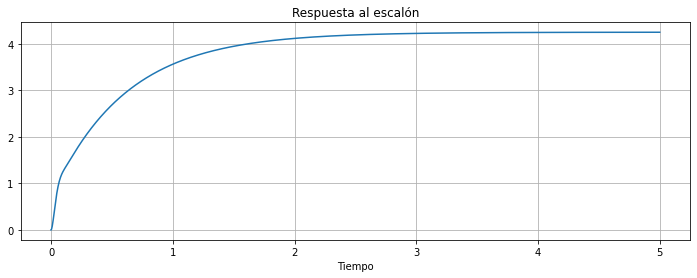

In [26]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(t,y)
ax.set_title('Respuesta al escalón')
ax.set_xlabel('Tiempo')
ax.grid()

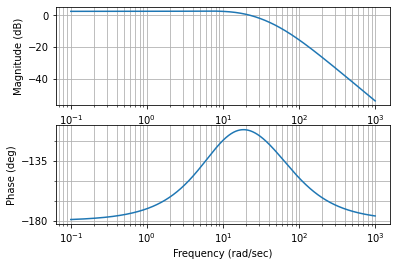

In [27]:
L=-G*d1*d2*kd2*k3
ctrl.bode(L, dB=True);

In [28]:
fig=plt.gcf()
fig.set_size_inches(12,8)

<Figure size 864x576 with 0 Axes>

In [29]:
G

TransferFunction(array([-40]), array([    1,    20,  -100, -2000]))

In [30]:
G.pole()

array([ 10., -20., -10.])

Para lograr un controlador que en principio funcione y epnsar de otra manera los lead-lag podemos hacer loop-shaping, y después ajusta a nuestro a lo que necesitemos.

In [31]:
Cls=((s+10)*(s+10)*(s+20))/s

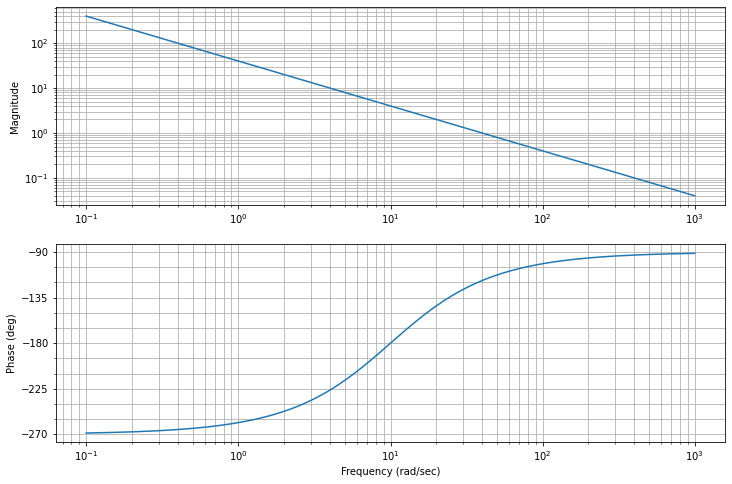

In [32]:
ctrl.bode(-G*Cls);
fig=plt.gcf()
fig.set_size_inches(12,8)

Analizamos que margen de fase tenemos a 22 rad y luego vemos la respuesta. Podemos después redisenar y mejorar aumentando la frecuencia de corte. Recordar que los isstemas inestables son más faciles de controlar más rápido que lento

In [33]:
kls=1/np.abs((G*Cls)(wc*1j))

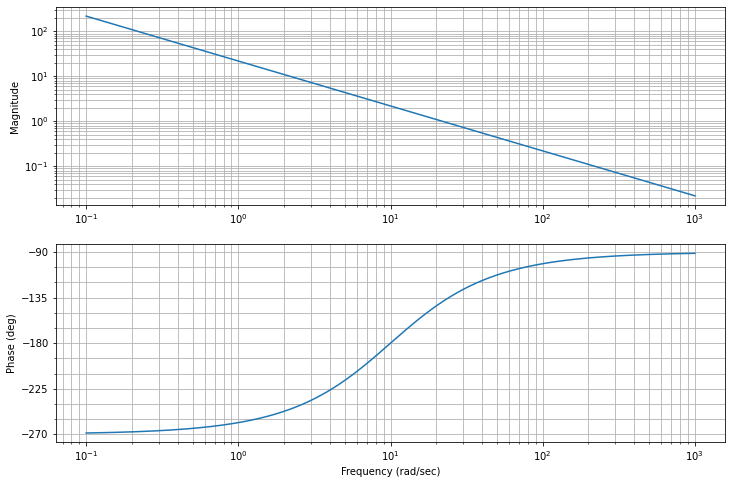

In [34]:
ctrl.bode(-G*Cls*kls);
fig=plt.gcf()
fig.set_size_inches(12,8)

In [35]:
ctrl.stability_margins(-G*Cls*kls)

(0.4545454545454543,
 41.112090439166934,
 0.6422688979612567,
 9.999999999999996,
 22.000000000000007,
 16.94186037737797)

In [36]:
T=ctrl.feedback(-G*Cls*kls)
t,y=ctrl.step_response(T)

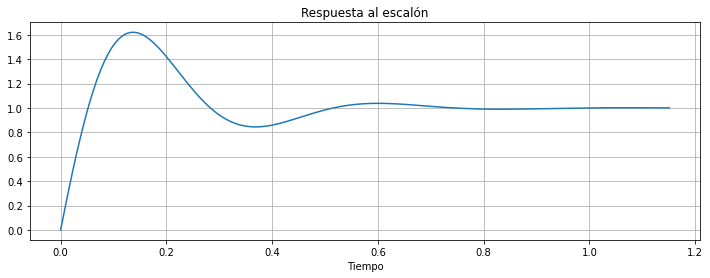

In [37]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(t,y)
ax.set_title('Respuesta al escalón')
ax.set_xlabel('Tiempo')
ax.grid()

In [38]:
Cls

TransferFunction(array([   1,   40,  500, 2000]), array([1, 0]))

In [39]:
Cls2=Cls*1/(s/400+1)**2
Cls2

TransferFunction(array([   160000,   6400000,  80000000, 320000000]), array([     1,    800, 160000,      0]))

In [40]:
Tu=ctrl.feedback(-Cls2,G)
t,y=ctrl.step_response(Tu, T=np.linspace(0,1,2000))

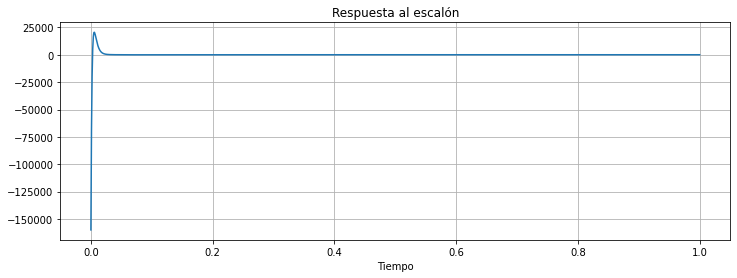

In [41]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(t,y)
ax.set_title('Respuesta al escalón')
ax.set_xlabel('Tiempo')
ax.grid()